In [1]:
# Imports
import os
import numpy as np
import seqdata as sd

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
# Set-up all file paths
data_dir = "/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/results/sequence_models"
peaks = os.path.join(data_dir, "matched_peaks", "beta_1.bed")
signal = os.path.join(data_dir, "insertion_counts", "beta_1_unstranded.bw")
fasta = "/cellar/users/aklie/data/ref/genomes/hg38/hg38.fa"
peaks, signal

('/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/results/sequence_models/matched_peaks/beta_1.bed',
 '/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/results/sequence_models/insertion_counts/beta_1_unstranded.bw')

In [6]:
# Make output directory if doesn't exist
out = os.path.join(data_dir, "zarrs", "beta_1.zarr")
out

'/cellar/users/aklie/data/datasets/Chiou2021_islet_snATAC-seq/results/sequence_models/zarrs/beta_1.zarr'

In [7]:
# Build SeqData
sdata = sd.from_region_files(
    sd.GenomeFASTA('seq',
        fasta,
        batch_size=10000,
        n_threads=4,
    ),
    sd.BigWig(
        'cov',
        [signal],
        ["beta_1"],
        batch_size=10000,
        n_jobs=4,
        threads_per_job=2,
    ),
    path=out,
    fixed_length=2114,
    bed=peaks,
    overwrite=True,
    max_jitter=128
)
sdata.load()

100%|██████████| 388068/388068 [00:14<00:00, 26077.35it/s]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 388068/388068 [01:01<00:00, 6289.38it/s] 


<xarray.Dataset>
Dimensions:     (_sequence: 388068, cov_sample: 1, _length: 2370)
Coordinates:
  * cov_sample  (cov_sample) object 'beta_1'
Dimensions without coordinates: _sequence, _length
Data variables:
    chrom       (_sequence) object 'chr1' 'chr1' 'chr1' ... 'chrY' 'chrY' 'chrY'
    chromEnd    (_sequence) int64 184756122 88993998 ... 56862500 56877298
    chromStart  (_sequence) int64 184753752 88991628 ... 56860130 56874928
    cov         (_sequence, cov_sample, _length) float32 0.0 0.0 0.0 ... 0.0 0.0
    name        (_sequence) object 'peak' 'peak' ... 'gc_matched_negative'
    seq         (_sequence, _length) |S1 b'T' b'T' b'T' b'C' ... b'T' b'C' b'A'
    strand      (_sequence) object '+' '+' '+' '+' '+' ... '+' '+' '+' '+' '+'
Attributes:
    length_dim:    _length
    max_jitter:    128
    sequence_dim:  _sequence

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tracks(tracks, interval, height=1.5, colors=None):
  _, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  if not isinstance(axes, np.ndarray):
    axes = [axes]
  for ax, (title, y) in zip(axes, tracks.items()):
    if colors is not None:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y, color=colors[title])
    else:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(f"{interval['chrom']}:{interval['start']}-{interval['end']}")
  plt.tight_layout()

In [17]:
# Get data
peak_seq_num = 0
peak_ser = sdata[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[peak_seq_num]
peak_vals = sdata["cov"][peak_seq_num].values.squeeze()

negative_seq_num = 350001
negative_ser = sdata[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[negative_seq_num]
negative_vals = sdata["cov"][negative_seq_num].values.squeeze()


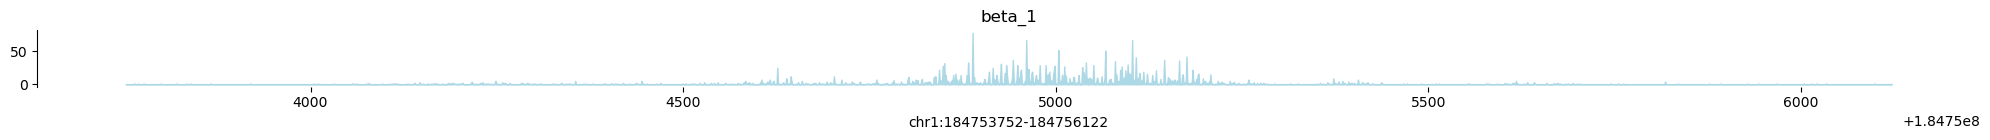

In [15]:
chrom = peak_ser["chrom"]
chromStart = peak_ser["chromStart"]
chromEnd = peak_ser["chromEnd"]
interval = dict(chrom=chrom, start=chromStart, end=chromEnd)
tracks = {
    "beta_1": peak_vals,
}
colors = {
    "beta_1": "lightblue",
}

# Plot tracks
plot_tracks(
    tracks=tracks,
    interval=interval,
    colors=colors
)
     

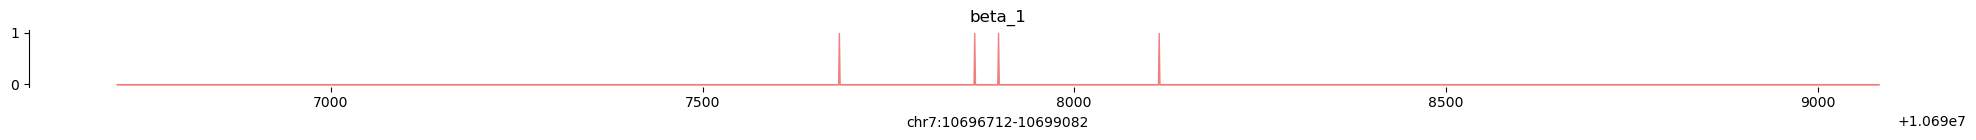

In [18]:
chrom = negative_ser["chrom"]
chromStart = negative_ser["chromStart"]
chromEnd = negative_ser["chromEnd"]
interval = dict(chrom=chrom, start=chromStart, end=chromEnd)
tracks = {
    "beta_1": negative_vals,
}
colors = {
    "beta_1": "lightcoral",
}

# Plot tracks
plot_tracks(
    tracks=tracks,
    interval=interval,
    colors=colors
)

In [19]:
sdata.close()

# DONE!

---